# Topic Modelling
The purpose of this code is to cluster which topic that has high interest. The topics might be the brand strength points or conversely the weaknesses. The model used is LDA using gensim library.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import gensim
from gensim.models import Phrases

from gensim import corpora, models

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array

from wordcloud import WordCloud, STOPWORDS
from matplotlib import colors as mcolors

In [2]:
df = pd.read_csv('gojek_processed.csv')
df.head()

,In Reply To,Author,Content,Date,Number of Likes,Number of Retweets,content_processed
0,NaN,@kumisantuy,"Chat terakhir tadi sore isinya:\n""Aku tudur ya...",2020-08-01 13:43:24,0.0,0.0,chat sore isi tudur barusan
1,@troesure,@nvishinoya,@troesure SERIUS.... gw suka degdegan klo lg n...,2020-08-01 13:42:10,0.0,0.0,troesure serius suka degdegan nggu for no reason
2,@krimykripy,@krimykripy,@collegemenfess dan pas hp uda mati ternyata p...,2020-08-01 13:41:33,0.0,0.0,collegemenfess hp ssudahh mati nyata posisi or...
3,@collegemenfess,@krimykripy,@collegemenfess inget banget dulu pertama ke k...,2020-08-01 13:41:19,0.0,0.0,collegemenfess kota rantau tanin ibu kos cari ...
4,@shellirachel,@findayaindo,"@shellirachel Hai kak, kami dari Findaya partn...",2020-08-01 13:41:12,0.0,0.0,shellirachel hai findaya partner tangan paylat...


In [3]:
df['content_processed'].fillna('', inplace=True)

In [4]:
#split words in processed text document
text = df['content_processed']
text_list = [i.split() for i in text]

print(len(text_list))

6707


In [5]:
#create bigram and trigram
bigram = Phrases(text_list, min_count=10)
trigram = Phrases(bigram[text_list])

#add to text_list
for idx in range(len(text_list)):
    for token in bigram[text_list[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            text_list[idx].append(token)
    for token in trigram[text_list[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            text_list[idx].append(token)

In [6]:
# Create a dictionary representation of the documents.
dictionary = corpora.Dictionary(text_list)

dictionary.filter_extremes(no_below=15, no_above=0.02) 
#no_below (int, optional) – Keep tokens which are contained in at least no_below documents.
#no_above (float, optional) – Keep tokens which are contained in no more than no_above documents (fraction of total corpus size, not an absolute number).

print(dictionary)

Dictionary(656 unique tokens: ['barusan', 'chat', 'isi', 'sore', 'for']...)


In [7]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in text_list]

print(len(doc_term_matrix))
print(doc_term_matrix[10])

6707
[(51, 1), (52, 1), (53, 1), (54, 1)]


In [8]:
#corpus
tfidf = models.TfidfModel(doc_term_matrix) #build TF-IDF model
corpus_tfidf = tfidf[doc_term_matrix]

In [9]:
#function to compute coherence value for evaluation
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, iterations=100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list, coherence_values

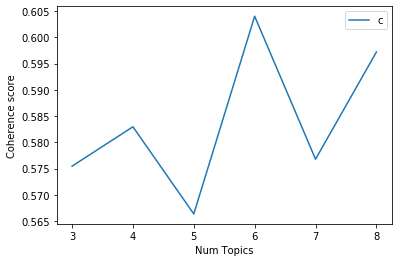

In [10]:
#plot coherence value for model with 'start' number of topic to 'limit'-1 number of topic
start=3
limit=9
step=1
model_list, coherence_values = compute_coherence_values(dictionary, corpus=corpus_tfidf, 
                                                        texts=text_list, start=start, limit=limit, step=step)
#show graphs
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [11]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6))

Num Topics = 3  has Coherence Value of 0.575464
Num Topics = 4  has Coherence Value of 0.582969
Num Topics = 5  has Coherence Value of 0.566385
Num Topics = 6  has Coherence Value of 0.604001
Num Topics = 7  has Coherence Value of 0.576795
Num Topics = 8  has Coherence Value of 0.597196


In [21]:
#show words with highest weight in each topic
top_words_per_topic = []
for t in range(model.num_topics):
    top_words_per_topic.extend([(t, ) + x for x in model.show_topic(t, topn = 10)])#pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'P']).to_csv("top_words.csv")
df_topwords = pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word','P'])
df_topwords

,Topic,Word,P
0,0,paylater,0.016785
1,0,sbyfess,0.016422
2,0,keren,0.014862
3,0,mesen,0.013278
4,0,bentar,0.013062
5,0,ajar,0.012368
6,0,bikin,0.012164
7,0,juenggak,0.012126
8,0,tolong,0.011945
9,0,gopayindonesia,0.011721


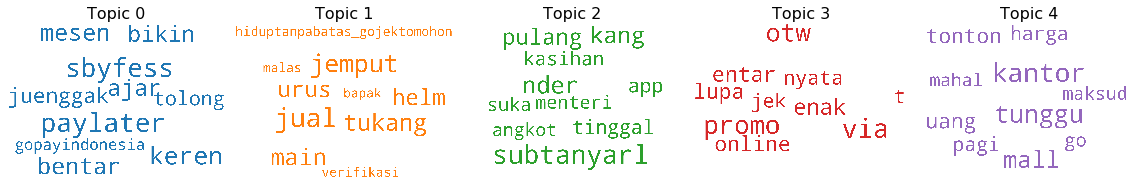

In [22]:
#word cloud
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 5, figsize=(16,16), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Labelling

In [23]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)`
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4)]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [24]:
df_topic_sents_keywords = format_topics_sentences(model, corpus_tfidf, df.Content)

# Format
df_dominant_topic = df_topic_sents_keywords
df_dominant_topic.columns = ['Dominant_Topic', 'Topic_Perc_Contrib', 'Text']
df_dominant_topic = df_dominant_topic.round(2)
df_dominant_topic.head(10)

,Dominant_Topic,Topic_Perc_Contrib,Text
0,1.0,0.38,"Chat terakhir tadi sore isinya:\n""Aku tudur ya..."
1,0.0,0.72,@troesure SERIUS.... gw suka degdegan klo lg n...
2,1.0,0.59,@collegemenfess dan pas hp uda mati ternyata p...
3,2.0,0.65,@collegemenfess inget banget dulu pertama ke k...
4,0.0,0.83,"@shellirachel Hai kak, kami dari Findaya partn..."
5,1.0,0.65,why suddenly doi gojek ini?:( padshal tadinya ...
6,5.0,0.58,@KDOYOUNGbc Abang gojek eh salah abang grab wk...
7,0.0,0.17,@Juljrsan @Diani_JKT48 @R_AmelJKT48 aakk nenen...
8,5.0,0.58,@xyzmsa Kirim pake gojek yaa
9,0.0,0.17,@injuniee12 GOJEK SAJA


In [25]:
df_final = df.merge(df_dominant_topic, how='left', left_on='Content', right_on='Text')

There are tweets that have 0.17 percentage for all topics, or in other words cannot be specified into a certain cluster. These tweets are labeled differently in this case I use number 10, thus, they will have their own cluster.

In [32]:
df_final.loc[df_final['Topic_Perc_Contrib']==0.17, 'Dominant_Topic'] = 10

Text(0.5, 1.0, 'Count per Topic')

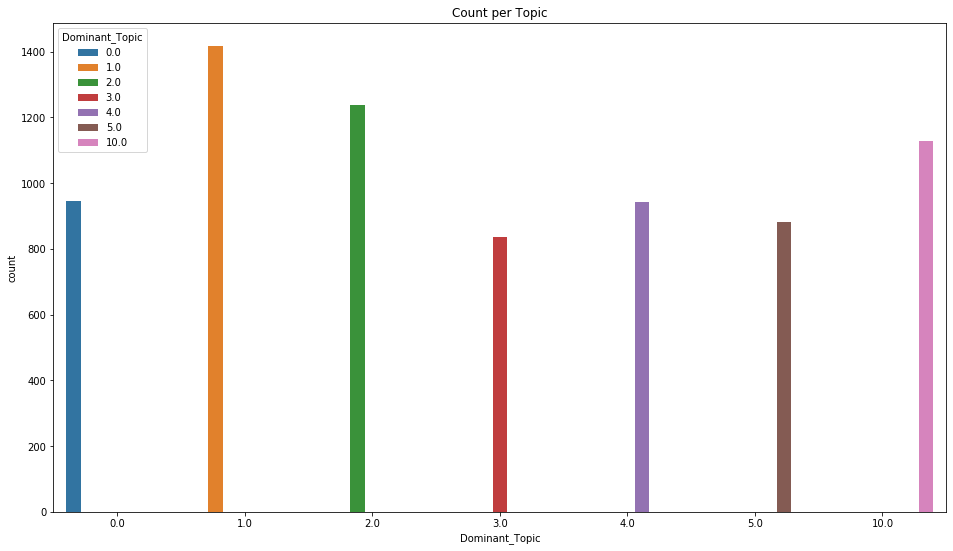

In [33]:
plt.figure(figsize=(16,9))
sns.countplot(x='Dominant_Topic', hue='Dominant_Topic', data=df_final)
plt.title('Count per Topic')

Topic 1 and topi 2 have the biggest proportion. However, it is still hard to make clusters with specific topics. It might because the tweets sampled are too general which showing the condition seems neutral. More dynamic results can be obtained if there are some events or issues regarding the brand.